# World & French sample

In [5]:
# source: '/efs/home/archive/prj_bdx/WIPR19DB/dta/'

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import BallTree
import math

In [7]:
!dir '/efs/home/archive/prj_bdx/WIPR19DB/dta/'

cluster_labels.dta     ipf_invctry.dta	   isp_citation.dta
famid_apptname.csv     ipf_invgeo.dta	   isp_geo.dta
famid_invname_std.csv  ipf_main.dta	   isp_main.dta
htec_labels.dta        ipf_topcit.dta	   isp_scif.dta
ipf_apptinfo.dta       ipf_totcit.dta	   isp_topcit.dta
ipf_htec.dta	       isp_autcluster.dta  isp_totcit.dta
ipf_invcluster.dta     isp_autctry.dta	   member_states.dta


# Declarations

In [8]:
samplesize = 100000
r_km = 6378.137 # 6371 # multiplier to convert to km (from unit distance)
# 6356.752 km at the poles to 6378.137 km at equator

# World (pats)

In [9]:
# Full dataset inventors
dfinv = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/ipf_invgeo.dta', index_col='fam_id')  

In [10]:
dfinv.head()

,invgeo_lat,invgeo_lng,invgeo_wgt
fam_id,,,
58,49.8647,8.66091,0.500000
58,49.9679,8.66340,0.500000
76,50.8146,3.05979,0.500000
76,50.9488,3.27389,0.500000
98,53.5773,9.96754,0.333333


In [11]:
# Full dataset main
dfmain = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/ipf_main.dta', index_col='fam_id')  

In [12]:
dfmain = dfmain.drop(columns=['fam_date', 'fam_pct', 'fam_size', 'fam_nr_offices']) 

In [13]:
dfmain.count()

fam_year    8955990
dtype: int64

In [14]:
df = pd.merge(dfmain,dfinv, on='fam_id')
# df = pd.merge(dfmain,dfinv, on='fam_id', copy=True)

In [16]:
df.rename(columns={'fam_year': 'year', 'invgeo_lat': 'lat', 'invgeo_lng': 'lng', 'invgeo_wgt': 'wgt'}, inplace=True)

In [17]:
df.head()

,year,lat,lng,wgt
fam_id,,,,
58,2004,49.8647,8.66091,0.500000
58,2004,49.9679,8.66340,0.500000
76,2005,50.8146,3.05979,0.500000
76,2005,50.9488,3.27389,0.500000
98,2006,53.5773,9.96754,0.333333


In [18]:
df.groupby(['year'])['wgt'].sum()

year
1970     24812.0
1971     28344.0
1972     33365.0
1973     38252.0
1974     41674.0
1975     43593.0
1976     44300.0
1977     45057.0
1978     49024.0
1979     53415.0
1980     58582.0
1981     62464.0
1982     64020.0
1983     67686.0
1984     72844.0
1985     77413.0
1986     81612.0
1987     91295.0
1988     97554.0
1989    106454.0
1990    108951.0
1991    105232.0
1992    105789.0
1993    109134.0
1994    114194.0
1995    127386.0
1996    142858.0
1997    159246.0
1998    172484.0
1999    194888.0
2000    223328.0
2001    218763.0
2002    225783.0
2003    239100.0
2004    261174.0
2005    276186.0
2006    285858.0
2007    289716.0
2008    280849.0
2009    279334.0
2010    304666.0
2011    326493.0
2012    335795.0
2013    345350.0
2014    335229.0
2015    286995.0
2016    189402.0
2017     69925.0
2018      2378.0
Name: wgt, dtype: float32

In [19]:
year1 = 2013
year0 = 2003

In [20]:
df1= df[df['year']==year1]
df1 = df1.drop(columns=['year']) 
print('before:', df1.wgt.sum())
df1 = df1.groupby(['lat','lng'],as_index=False).sum()
print('after:', df1.wgt.sum())

345350.06
345350.03


In [21]:
df0= df[df['year']==year0]
df0 = df0.drop(columns=['year']) 
print('before:', df0.wgt.sum())
df0 = df0.groupby(['lat','lng'],as_index=False).sum()
print('after:', df0.wgt.sum())

239100.03
239100.0


In [23]:
print(df0.count(), df1.count())

lat    125879
lng    125879
wgt    125879
dtype: int64 lat    124958
lng    124958
wgt    124958
dtype: int64


In [43]:
for x in df1, df0:
    # round up wgts
    x['wgt']=x['wgt'].apply(np.ceil)
    # convert coords to radians 
    x['radlat']=np.deg2rad(x['lat'].values)
    x['radlng']=np.deg2rad(x['lng'].values)
    print('total wgts:', x.wgt.sum())
    print('unwgt stats:', x.describe())

total wgts: 397295.0
unwgt stats:                  lat            lng            wgt         radlat  \
count  124958.000000  124958.000000  124958.000000  124958.000000   
mean       41.669599       5.708568       3.179428       0.727272   
std        15.271732      73.724378      35.475933       0.266542   
min       -46.388400    -168.087010       1.000000      -0.809630   
25%        36.436850     -71.250000       1.000000       0.635943   
50%        45.246150       7.722930       1.000000       0.789694   
75%        50.220800      18.314200       2.000000       0.876518   
max        70.253300     176.942500    9286.000000       1.226151   

              radlng  
count  124958.000000  
mean        0.099633  
std         1.286733  
min        -2.933672  
25%        -1.243547  
50%         0.134791  
75%         0.319643  
max         3.088229  
total wgts: 293757.0
unwgt stats:                  lat            lng            wgt         radlat  \
count  125879.000000  125879.00000

<AxesSubplot: title={'center': 'Patent families (2013)'}, xlabel='lng', ylabel='lat'>

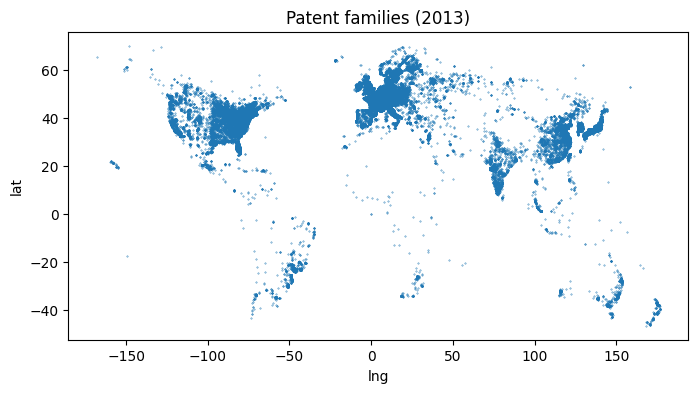

In [35]:
df1.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Patent families ('+str(year1)+')')

<AxesSubplot: title={'center': 'Patent families (2003)'}, xlabel='lng', ylabel='lat'>

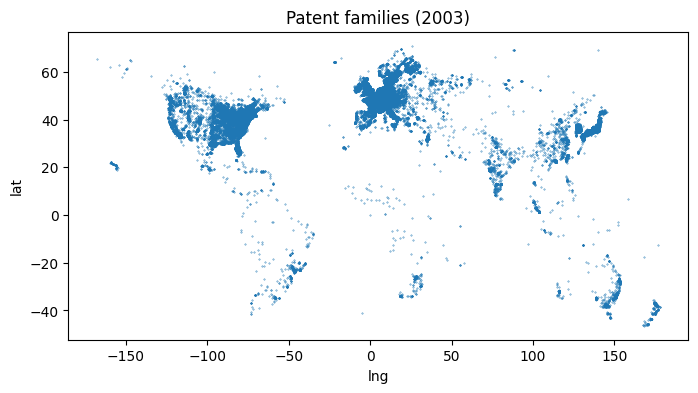

In [37]:
df0.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Patent families ('+str(year0)+')')

## DF1

In [44]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df1[['radlat','radlng']])
distances, idx = nn.kneighbors(df1[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [45]:
# distance from radians to KMs
distances_km=distances*r_km

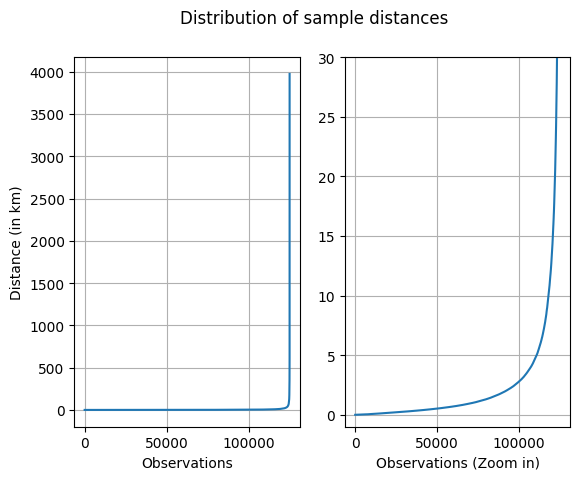

In [60]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 30, ymin=-1)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [49]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df1[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df1.wgt)
N=tree.query_radius(df1[['radlat','radlng']], r=radius, count_only=True)

In [50]:
df1['N']=N.tolist()
df1.head()

,lat,lng,wgt,radlat,radlng,N
0,-46.3884,168.38010,1.0,-0.809630,2.938787,1
1,-45.9129,170.47800,1.0,-0.801331,2.975402,10
2,-45.8984,170.49010,1.0,-0.801078,2.975614,10
3,-45.8833,170.38330,1.0,-0.800815,2.973750,8
4,-45.8833,170.46671,2.0,-0.800815,2.975205,10


In [51]:
df1.describe()

,lat,lng,wgt,radlat,radlng,N
count,124958.000000,124958.000000,124958.000000,124958.000000,124958.000000,124958.000000
mean,41.669599,5.708568,3.179428,0.727272,0.099633,154.415692
std,15.271732,73.724378,35.475933,0.266542,1.286733,272.147921
min,-46.388400,-168.087010,1.000000,-0.809630,-2.933672,1.000000
25%,36.436850,-71.250000,1.000000,0.635943,-1.243547,18.000000
50%,45.246150,7.722930,1.000000,0.789694,0.134791,58.000000
75%,50.220800,18.314200,2.000000,0.876518,0.319643,162.000000
max,70.253300,176.942500,9286.000000,1.226151,3.088229,1888.000000


In [52]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df1.N, weights=df1.wgt, ddof=1) 
uwdf = DescrStatsW(df1.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

277.7451188663336 154.41569167240192
441.0077904714151 272.14792101974433
p
0.00       1
0.25      36
0.50     103
0.75     294
1.00    1888
dtype: int64 p
0.00       1
0.25      18
0.50      58
0.75     162
1.00    1888
dtype: int64


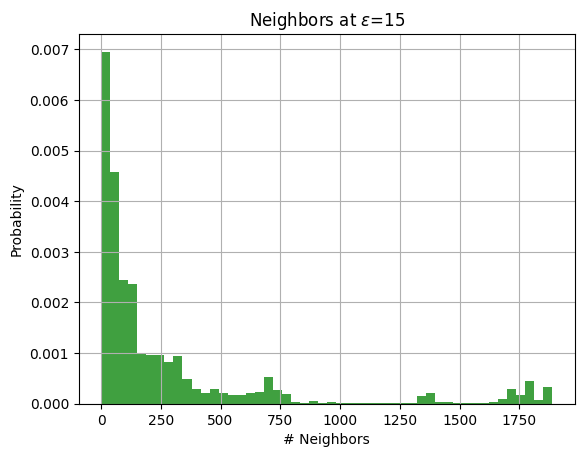

In [53]:
n, bins, patches = plt.hist(df1.N, 50, density=True, facecolor='g', alpha=0.75, weights=df1.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [54]:
# Number of weighted observations
nobswgt = df1.wgt.sum()
nobswgt

397295.0

In [56]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df1[['radlat','radlng']], sample_weight=df1.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df1['labels']=labels.tolist()
    n_noise = df1[df1['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.000000,0.010101,None,7275,0.0,0.000000
1,2,2,99.079777,0.011018,None,3619,3656.0,0.920223
2,3,2,99.079777,0.021441,None,3619,3656.0,0.920223
3,4,3,98.473175,0.025762,None,2414,6066.0,1.526825
4,5,4,98.001988,0.031600,None,1858,7938.0,1.998012


In [57]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,1695,35.920161,6.184032,None,18,254586.0,64.079839
95,96,1725,35.897756,7.974439,None,18,254675.0,64.102244
96,97,1784,35.831308,10.943769,None,18,254939.0,64.168692
97,98,1791,35.792798,16.896399,None,18,255092.0,64.207202
98,99,1851,35.685325,34.685325,None,18,255519.0,64.314675


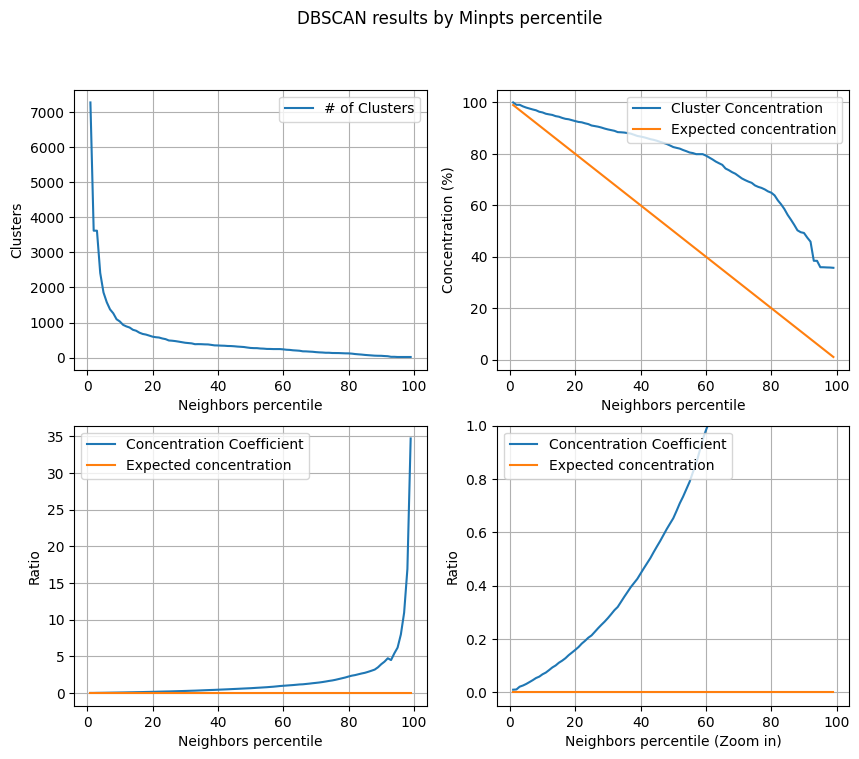

In [65]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(10, 8))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(2,2,1)
plt.plot(dfplt['pctile'], dfplt['n_clusters'], label = "# of Clusters")
plt.xlabel('Neighbors percentile')
plt.ylabel('Clusters')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,2)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(2,2,4)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## DF0

In [67]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df0[['radlat','radlng']])
distances, idx = nn.kneighbors(df0[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [68]:
# distance from radians to KMs
distances_km=distances*r_km

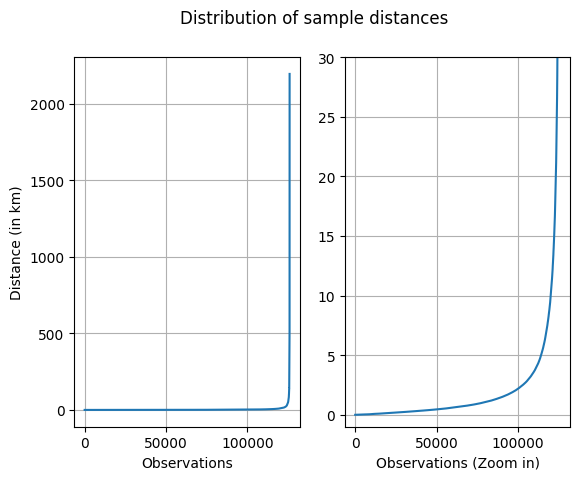

In [69]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 30, ymin=-1)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [70]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df0[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df0.wgt)
N=tree.query_radius(df0[['radlat','radlng']], r=radius, count_only=True)

In [71]:
df0['N']=N.tolist()
df0.head()

,lat,lng,wgt,radlat,radlng,N
0,-46.40000,168.35001,1.0,-0.809833,2.938262,1
1,-46.23148,169.75117,1.0,-0.806892,2.962717,1
2,-46.13330,167.68300,1.0,-0.805178,2.926620,1
3,-46.09880,168.94600,1.0,-0.804576,2.948664,1
4,-46.08330,168.05000,1.0,-0.804305,2.933026,1


In [72]:
df0.describe()

,lat,lng,wgt,radlat,radlng,N
count,125879.000000,125879.000000,125879.000000,125879.000000,125879.000000,125879.000000
mean,42.238858,4.033303,2.333646,0.737207,0.070394,216.884222
std,14.275480,77.407009,15.816994,0.249154,1.351007,421.204467
min,-46.400000,-168.087010,1.000000,-0.809833,-2.933672,1.000000
25%,36.396730,-73.824700,1.000000,0.635243,-1.288484,25.000000
50%,44.825100,7.045620,1.000000,0.782346,0.122969,79.000000
75%,50.073950,16.361500,1.000000,0.873955,0.285562,201.000000
max,70.982300,178.235370,2142.000000,1.238875,3.110794,2850.000000


In [73]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df0.N, weights=df0.wgt, ddof=1) 
uwdf = DescrStatsW(df0.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

377.9648382847047 216.88422214984232
638.7168717421184 421.20446683786446
p
0.00       1
0.25      42
0.50     119
0.75     348
1.00    2850
dtype: int64 p
0.00       1
0.25      25
0.50      79
0.75     201
1.00    2850
dtype: int64


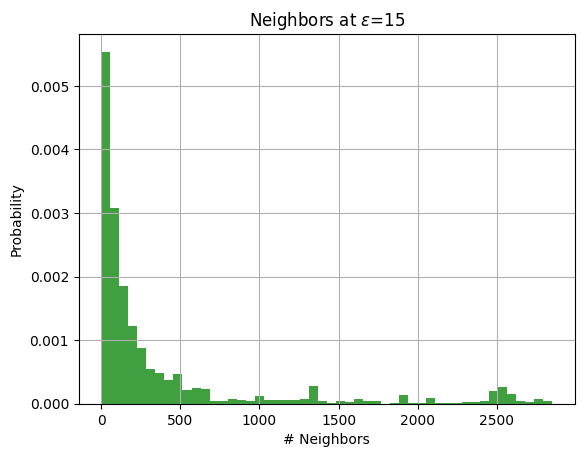

In [74]:
n, bins, patches = plt.hist(df0.N, 50, density=True, facecolor='g', alpha=0.75, weights=df0.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [75]:
# Number of weighted observations
nobswgt = df0.wgt.sum()
nobswgt

293757.0

In [76]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df0[['radlat','radlng']], sample_weight=df0.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df0['labels']=labels.tolist()
    n_noise = df0[df0['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.000000,0.010101,None,5900,0.0,0.000000
1,2,2,98.929047,0.009480,None,2754,3146.0,1.070953
2,3,2,98.929047,0.019887,None,2754,3146.0,1.070953
3,4,3,98.283615,0.023788,None,1806,5042.0,1.716385
4,5,4,97.816563,0.029648,None,1417,6414.0,2.183437


In [77]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,2305,25.476497,4.095299,None,7,218918.0,74.523503
95,96,2486,24.682647,5.170662,None,6,221250.0,75.317353
96,97,2528,24.652010,7.217337,None,6,221340.0,75.347990
97,98,2561,24.633628,11.316814,None,6,221394.0,75.366372
98,99,2633,24.100870,23.100870,None,6,222959.0,75.899130


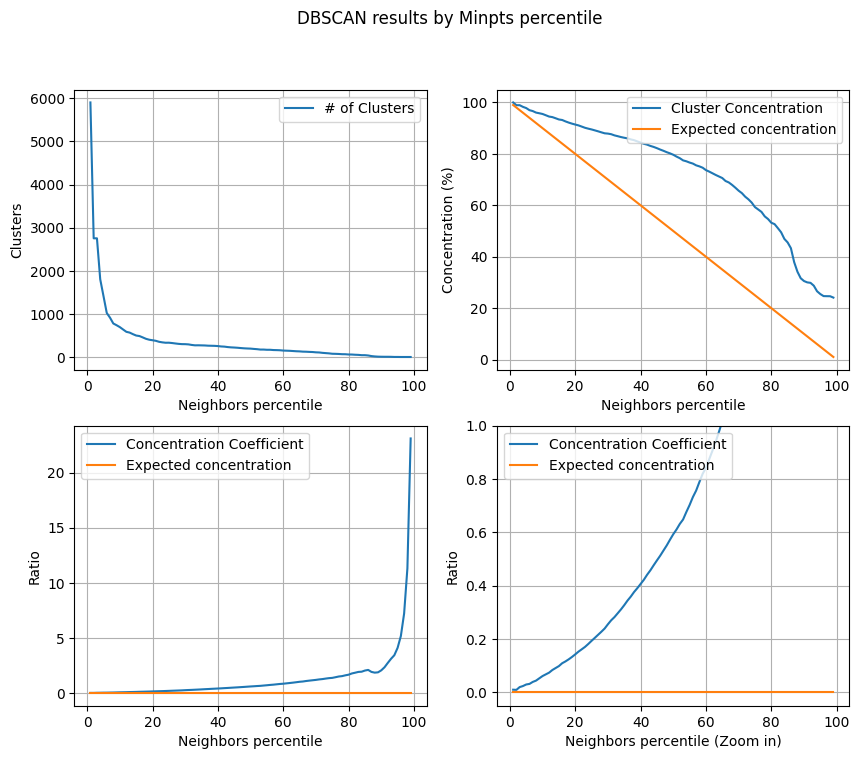

In [78]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(10, 8))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(2,2,1)
plt.plot(dfplt['pctile'], dfplt['n_clusters'], label = "# of Clusters")
plt.xlabel('Neighbors percentile')
plt.ylabel('Clusters')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,2)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(2,2,4)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# World (Pubs)

In [79]:
dfaut = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/isp_geo.dta', index_col='isp_id')  

In [80]:
dfaut.head()

,lat,lng,autgeo_q,autgeo_wgt
isp_id,,,,
1,35.201698,-89.971497,1,1.000000
3,38.951698,-92.334099,2,1.000000
5,38.986301,-3.929100,2,1.000000
6,34.053101,-118.380600,1,0.166667
6,34.147800,-118.144501,1,0.166667


In [81]:
# Full dataset main
dfmain = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/isp_main.dta', index_col='isp_id')  

In [84]:
dfmain = dfmain.drop(columns=['pubdate']) 

In [85]:
dfmain.head()

,pubyear
isp_id,
1,2012
3,2012
5,2012
6,2012
7,2012


In [86]:
dfmain.count()

pubyear    23789354
dtype: int64

In [87]:
df = pd.merge(dfmain,dfaut, on='isp_id')
# df = pd.merge(dfmain,dfinv, on='fam_id', copy=True)

In [ ]:
df = df.drop(columns=['autgeo_q']) 
df.head()

In [92]:
df.rename(columns={'pubyear': 'year', 'autgeo_wgt': 'wgt'}, inplace=True)

In [93]:
df.head()

,year,lat,lng,wgt
isp_id,,,,
1,2012,35.201698,-89.971497,1.000000
3,2012,38.951698,-92.334099,1.000000
5,2012,38.986301,-3.929100,1.000000
6,2012,34.053101,-118.380600,0.166667
6,2012,34.147800,-118.144501,0.166667


In [94]:
df.groupby(['year'])['wgt'].sum()

year
1997          2.0
1998     767439.0
1999     790328.0
2000     805207.0
2001     803546.0
2002     844209.0
2003     890355.0
2004     966129.0
2005    1007927.0
2006    1069256.0
2007    1119942.0
2008    1166422.0
2009    1223731.0
2010    1263631.0
2011    1337455.0
2012    1415340.0
2013    1494984.0
2014    1540706.0
2015    1550021.0
2016    1437855.0
2017    1534509.0
2018        252.0
Name: wgt, dtype: float32

In [95]:
year1 = 2013
year0 = 2003

In [96]:
df1= df[df['year']==year1]
df1 = df1.drop(columns=['year']) 
print('before:', df1.wgt.sum())
df1 = df1.groupby(['lat','lng'],as_index=False).sum()
print('after:', df1.wgt.sum())

before: 1494983.5
after: 1494984.1


In [97]:
df0= df[df['year']==year0]
df0 = df0.drop(columns=['year']) 
print('before:', df0.wgt.sum())
df0 = df0.groupby(['lat','lng'],as_index=False).sum()
print('after:', df0.wgt.sum())

before: 890354.94
after: 890354.94


In [98]:
print(df0.count(), df1.count())

lat    33282
lng    33282
wgt    33282
dtype: int64 lat    45300
lng    45300
wgt    45300
dtype: int64


In [99]:
for x in df1, df0:
    # round up wgts
    x['wgt']=x['wgt'].apply(np.ceil)
    # convert coords to radians 
    x['radlat']=np.deg2rad(x['lat'].values)
    x['radlng']=np.deg2rad(x['lng'].values)
    print('total wgts:', x.wgt.sum())
    print('unwgt stats:', x.describe())

total wgts: 1518314.0
unwgt stats:                 lat           lng           wgt        radlat        radlng
count  45300.000000  45300.000000  45300.000000  45300.000000  45300.000000
mean      35.499268      8.448827     33.516865      0.619579      0.147460
std       21.010332     79.367134    218.162552      0.366699      1.385218
min      -89.997597   -175.201797      1.000000     -1.570754     -3.057848
25%       32.194030    -72.762650      1.000000      0.561892     -1.269948
50%       40.576649      5.934500      2.000000      0.708196      0.103577
75%       50.021423     75.246437      7.000000      0.873039      1.313298
max       79.621803    178.441483  19033.000000      1.389663      3.114391
total wgts: 905900.0
unwgt stats:                 lat           lng           wgt        radlat        radlng
count  33282.000000  33282.000000  33282.000000  33282.000000  33282.000000
mean      37.192009      2.504670     27.218918      0.649123      0.043715
std       19.812708

<AxesSubplot: title={'center': 'WOS articles (2013)'}, xlabel='lng', ylabel='lat'>

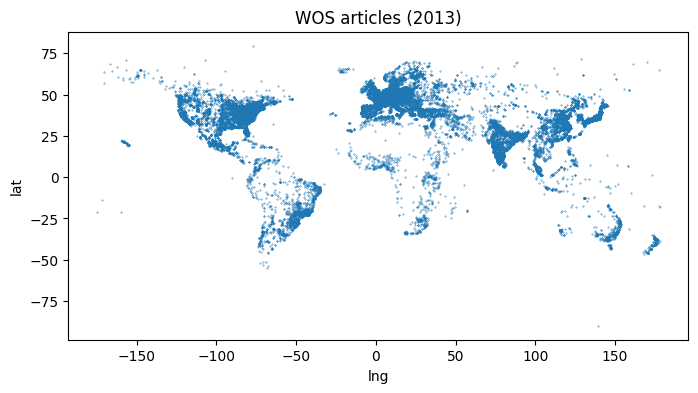

In [100]:
df1.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='WOS articles ('+str(year1)+')')

<AxesSubplot: title={'center': 'WOS articles (2003)'}, xlabel='lng', ylabel='lat'>

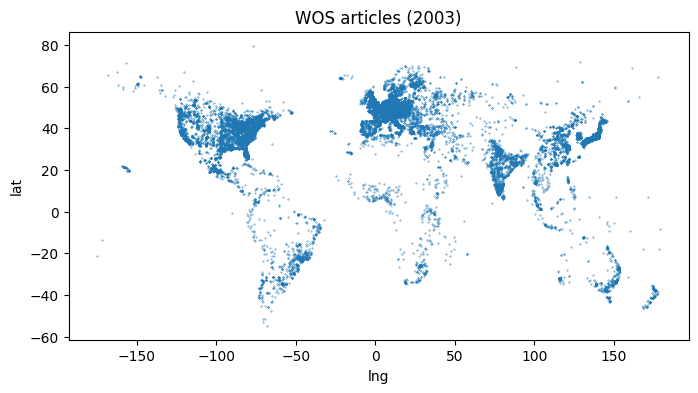

In [101]:
df0.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='WOS articles ('+str(year0)+')')

## DF1

In [102]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df1[['radlat','radlng']])
distances, idx = nn.kneighbors(df1[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [103]:
# distance from radians to KMs
distances_km=distances*r_km

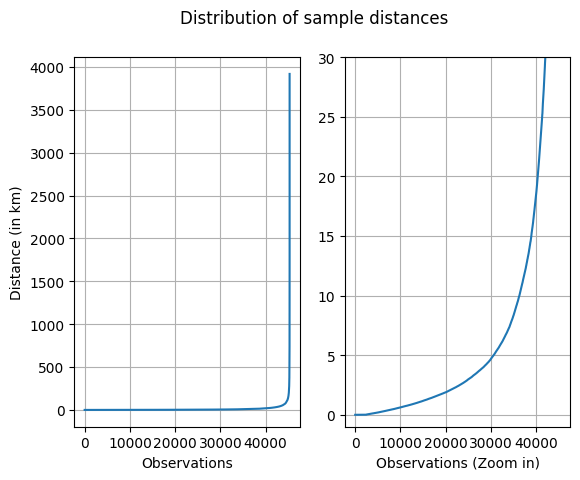

In [104]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 30, ymin=-1)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [105]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df1[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df1.wgt)
N=tree.query_radius(df1[['radlat','radlng']], r=radius, count_only=True)

In [106]:
df1['N']=N.tolist()
df1.head()

,lat,lng,wgt,radlat,radlng,N
0,-89.997597,139.272903,1.0,-1.570754,2.430771,1
1,-54.799999,-68.300003,23.0,-0.956440,-1.192060,1
2,-53.787689,-67.709457,1.0,-0.938772,-1.181753,1
3,-53.154831,-70.911293,16.0,-0.927727,-1.237635,1
4,-51.729870,-72.506027,1.0,-0.902857,-1.265469,1


In [107]:
df1.describe()

,lat,lng,wgt,radlat,radlng,N
count,45300.000000,45300.000000,45300.000000,45300.000000,45300.000000,45300.000000
mean,35.499268,8.448827,33.516865,0.619579,0.147460,45.452759
std,21.010332,79.367134,218.162552,0.366699,1.385218,107.994274
min,-89.997597,-175.201797,1.000000,-1.570754,-3.057848,1.000000
25%,32.194030,-72.762650,1.000000,0.561892,-1.269948,3.000000
50%,40.576649,5.934500,2.000000,0.708196,0.103577,11.000000
75%,50.021423,75.246437,7.000000,0.873039,1.313298,38.000000
max,79.621803,178.441483,19033.000000,1.389663,3.114391,759.000000


In [108]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df1.N, weights=df1.wgt, ddof=1) 
uwdf = DescrStatsW(df1.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

48.41719894567263 45.45275938189845
93.6980842931532 107.99427409687583
p
0.00      1
0.25      8
0.50     23
0.75     51
1.00    759
dtype: int64 p
0.00      1
0.25      3
0.50     11
0.75     38
1.00    759
dtype: int64


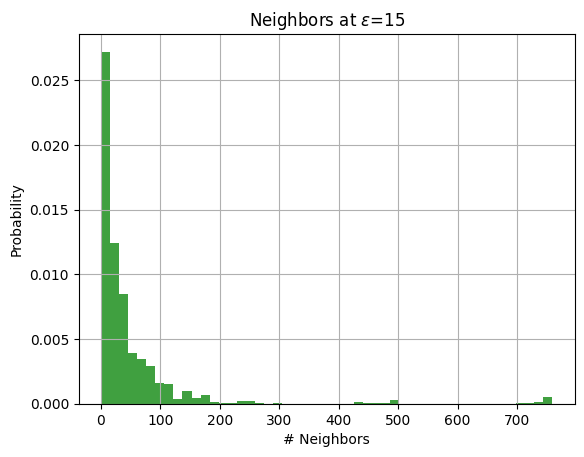

In [109]:
n, bins, patches = plt.hist(df1.N, 50, density=True, facecolor='g', alpha=0.75, weights=df1.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [110]:
# Number of weighted observations
nobswgt = df1.wgt.sum()
nobswgt

1518314.0

In [111]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df1[['radlat','radlng']], sample_weight=df1.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df1['labels']=labels.tolist()
    n_noise = df1[df1['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.000000,0.010101,None,9768,0.0,0.000000
1,2,1,100.000000,0.020408,None,9768,0.0,0.000000
2,3,1,100.000000,0.030928,None,9768,0.0,0.000000
3,4,1,100.000000,0.041667,None,9768,0.0,0.000000
4,5,2,99.765727,0.050166,None,6211,3557.0,0.234273


In [114]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,150,92.603045,17.520609,None,931,112309.0,7.396955
95,96,176,91.845626,21.961407,None,872,123809.0,8.154374
96,97,203,90.961553,29.320518,None,813,137232.0,9.038447
97,98,381,86.440815,42.220408,None,604,205871.0,13.559185
98,99,721,78.005143,77.005143,None,380,333951.0,21.994857


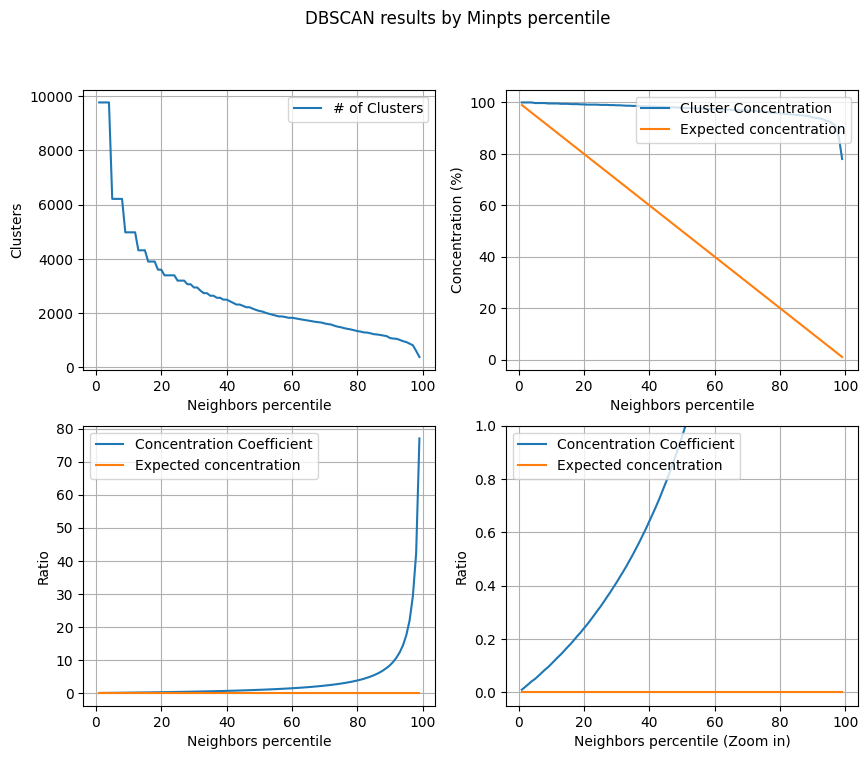

In [115]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(10, 8))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(2,2,1)
plt.plot(dfplt['pctile'], dfplt['n_clusters'], label = "# of Clusters")
plt.xlabel('Neighbors percentile')
plt.ylabel('Clusters')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,2)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(2,2,4)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## DF0

In [116]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df0[['radlat','radlng']])
distances, idx = nn.kneighbors(df0[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [117]:
# distance from radians to KMs
distances_km=distances*r_km

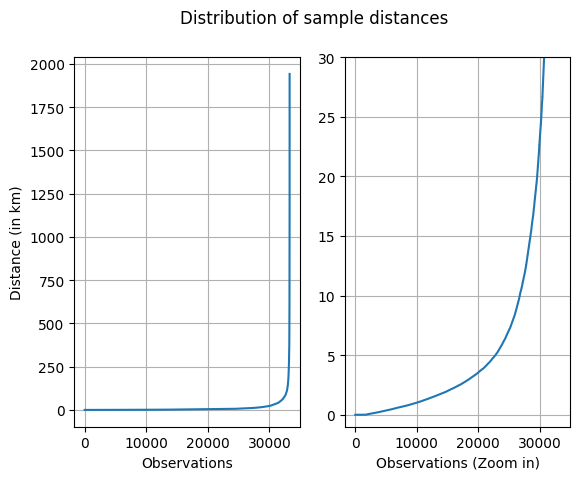

In [118]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 30, ymin=-1)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [119]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df0[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df0.wgt)
N=tree.query_radius(df0[['radlat','radlng']], r=radius, count_only=True)

In [120]:
df0['N']=N.tolist()
df0.head()

,lat,lng,wgt,radlat,radlng,N
0,-54.799999,-68.300003,9.0,-0.956440,-1.192060,1
1,-53.154831,-70.911293,4.0,-0.927727,-1.237635,1
2,-51.622608,-69.218132,2.0,-0.900984,-1.208084,1
3,-51.394001,-70.605499,5.0,-0.896995,-1.232298,1
4,-47.750340,-65.893822,1.0,-0.833401,-1.150064,1


In [121]:
df0.describe()

,lat,lng,wgt,radlat,radlng,N
count,33282.000000,33282.000000,33282.000000,33282.000000,33282.000000,33282.000000
mean,37.192009,2.504670,27.218918,0.649123,0.043715,38.554955
std,19.812708,80.814537,151.289551,0.345797,1.410480,80.529900
min,-54.799999,-175.201797,1.000000,-0.956440,-3.057848,1.000000
25%,34.275716,-75.863249,1.000000,0.598224,-1.324063,3.000000
50%,41.064499,2.950000,2.000000,0.716711,0.051487,11.000000
75%,50.251518,37.054427,7.000000,0.877054,0.646722,36.000000
max,79.621803,179.194168,7847.000000,1.389663,3.127528,516.000000


In [122]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df0.N, weights=df0.wgt, ddof=1) 
uwdf = DescrStatsW(df0.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

46.556580196489676 38.5549546301304
81.4809471529757 80.52989973481269
p
0.00      1
0.25      8
0.50     22
0.75     48
1.00    516
dtype: int64 p
0.00      1
0.25      3
0.50     11
0.75     36
1.00    516
dtype: int64


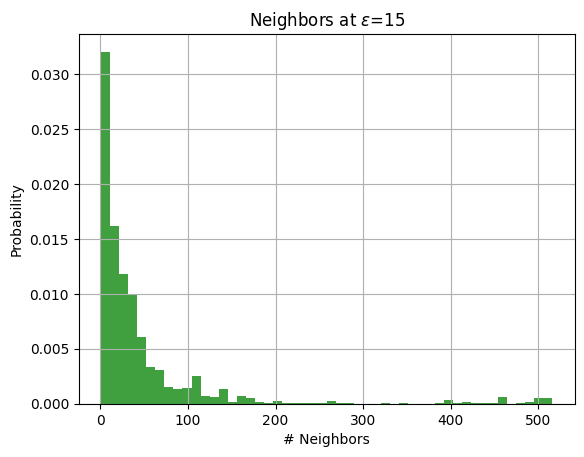

In [123]:
n, bins, patches = plt.hist(df0.N, 50, density=True, facecolor='g', alpha=0.75, weights=df0.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [124]:
# Number of weighted observations
nobswgt = df0.wgt.sum()
nobswgt

905900.0

In [125]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df0[['radlat','radlng']], sample_weight=df0.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df0['labels']=labels.tolist()
    n_noise = df0[df0['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.000000,0.010101,None,7266,0.0,0.000000
1,2,1,100.000000,0.020408,None,7266,0.0,0.000000
2,3,1,100.000000,0.030928,None,7266,0.0,0.000000
3,4,2,99.689259,0.038430,None,4451,2815.0,0.310741
4,5,2,99.689259,0.049361,None,4451,2815.0,0.310741


In [126]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,160,90.891710,17.178342,None,626,82512.0,9.108290
95,96,173,90.410420,21.602605,None,603,86872.0,9.589580
96,97,263,87.327188,28.109063,None,501,114803.0,12.672812
97,98,439,82.044928,40.022464,None,377,162655.0,17.955072
98,99,496,80.726129,79.726129,None,352,174602.0,19.273871


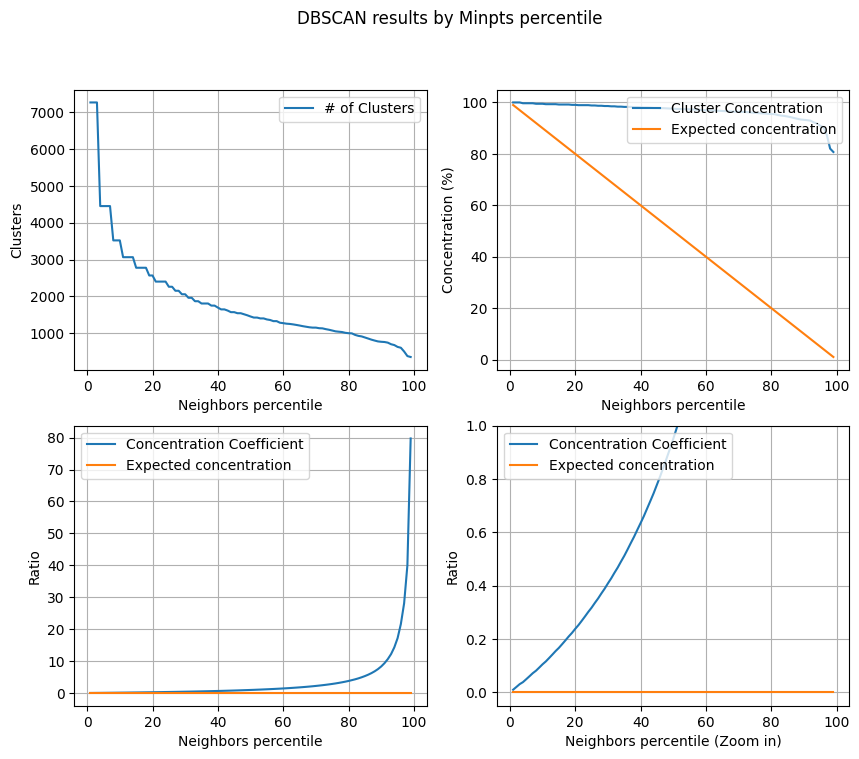

In [127]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(10, 8))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(2,2,1)
plt.plot(dfplt['pctile'], dfplt['n_clusters'], label = "# of Clusters")
plt.xlabel('Neighbors percentile')
plt.ylabel('Clusters')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,2)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(2,2,4)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [136]:
def get_var_name(variable):
    globals_dict = globals()
    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]


In [1]:
for x in df, dfinv, dfaut, dfmain:
    cur = sys.getsizeof(x)
    curname = get_var_name(x)
    print(curname, cur/1024/1024, 'Mb')
    

NameError: name 'df' is not defined

# France

## source: 
archive/prj_bdx/WIPR19DB/dta/ipf_invgeo.dta

## boundaries:
- North: 51°05' N (Bray-Dunes)
- South: 42°20' N (Puig de Comanegra)
- East: 8°13' E (Lauterbourg)
- West: 4°47' W (Pointe de Corsen)

In [3]:
# FR limits
north = 51 + 5/60
south = 42 + 20/60
east = 8 + 13/60
west = -4 - 47/60

In [4]:
#
print(north, south, west, east)
print((north-south)*.1)
print((east-west)*.1)
buffer = 1.5 # >than both above
bndn = north +  buffer
bnds = south - buffer
bnde = east + buffer
bndw = west - buffer

51.083333333333336 42.333333333333336 -4.783333333333333 8.216666666666667
0.875
1.3


In [ ]:
# TBC